##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Federated Learning for Image Classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.7.0/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.7.0/docs/tutorials/federated_learning_for_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

**NOTE**: This colab has been verified to work with the `0.7.0` version of the `tensorflow_federated` pip package, but the Tensorflow Federated project is still in pre-release development and may not work on `master`.

In this tutorial, we use the classic MNIST training example to introduce the
Federated Learning (FL) API layer of TFF, `tff.learning` - a set of
higher-level interfaces that can be used to perform common types of federated
learning tasks, such as federated training, against user-supplied models
implemented in TensorFlow.

This tutorial, and the Federated Learning API, are intended primarily for users
who want to plug their own TensorFlow models into TFF, treating the latter
mostly as a black box. For a more in-depth understanding of TFF and how to
implement your own federated learning algorithms, see the tutorials on the FC Core API - [Custom Federated Algorithms Part 1](custom_federated_algorithms_1.ipynb) and [Part 2](custom_federated_algorithms_2.ipynb).

For more on `tff.learning`, continue with the
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb),
tutorial which in addition to covering recurrent models, also demonstrates loading a
pre-trained serialized Keras model for refinement with federated learning
combined with evaluation using Keras.

## Before we start

Before we start, please run the following to make sure that your environment is
correctly setup. If you don't see a greeting, please refer to the
[Installation](../install.md) guide for instructions.

In [0]:
#@test {"skip": true}

# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# NOTE: The high-performance executor components used in this tutorial are not
# yet included in the released pip package; you may need to compile from source.
!pip install --quiet tensorflow_federated
!pip install --quiet  tf-nightly

# NOTE: Jupyter requires a patch to asyncio.
!pip install --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 317kB 4.9MB/s 
     |████████████████████████████████| 6.0MB 13.3MB/s 
     |████████████████████████████████| 102.2MB 243kB/s 
     |████████████████████████████████| 501kB 40.4MB/s 
     |████████████████████████████████| 4.1MB 35.2MB/s 
     |████████████████████████████████| 61kB 18.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [0]:
from __future__ import absolute_import, division, print_function

import collections
import warnings
from six.moves import range
import numpy as np
import six
import tensorflow as tf

warnings.simplefilter('ignore')

tf.compat.v1.enable_v2_behavior()

import tensorflow_federated as tff

np.random.seed(0)

NUM_CLIENTS = 10

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
# instead to use the default reference runtime.
if six.PY3:
  tff.framework.set_default_executor(
      tff.framework.create_local_executor(NUM_CLIENTS))

tff.federated_computation(lambda: 'Hello, World!')()

W0729 21:59:33.932531 140191347251072 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



b'Hello, World!'

## Preparing the input data

Let's start with the data. Federated learning requires a federated data set,
i.e., a collection of data from multiple users. Federated data is typically
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
which poses a unique set of challenges.

In order to facilitate experimentation, we seeded the TFF repository with a few
datasets, including a federated version of MNIST that contains a version of the [original NIST dataset](https://www.nist.gov/srd/nist-special-database-19) that has been re-processed using [Leaf](https://github.com/TalwalkarLab/leaf) so that the data is keyed by the original writer of the digits. Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

Here's how we can load it.

In [0]:
#@test {"output": "ignore"}
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 1s 0us/step


W0729 22:01:20.460442 140191347251072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0729 22:01:20.461725 140191347251072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:65: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`, an interface that allows you to enumerate the set
of users, to construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. Here's how
you can use this interface to explore the content of the data set. Keep in mind
that while this interface allows you to iterate over clients ids, this is only a
feature of the simulation data. As you will see shortly, client identities are
not used by the federated learning framework - their only purpose is to allow
you to select subsets of the data for simulations.

In [0]:
len(emnist_train.client_ids)

3383

In [0]:
emnist_train.output_types, emnist_train.output_shapes

(OrderedDict([('label', tf.int32), ('pixels', tf.float32)]),
 OrderedDict([('label', TensorShape([])), ('pixels', TensorShape([28, 28]))]))

In [0]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

5

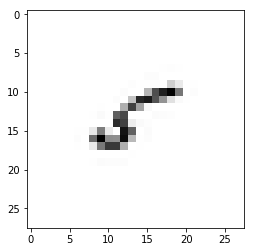

In [0]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid('off')
_ = plt.show()

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and renames the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [0]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500

def preprocess(dataset):

  def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['pixels'], [-1])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(
      SHUFFLE_BUFFER).batch(BATCH_SIZE)

Let's verify this worked.

In [0]:
#@test {"output": "ignore"}
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

sample_batch

W0729 22:03:23.626774 140191347251072 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[4],
                     [3],
                     [0],
                     [1],
                     [1],
                     [9],
                     [1],
                     [5],
                     [3],
                     [9],
                     [0],
                     [3],
                     [0],
                     [7],
                     [7],
                     [2],
                     [9],
                     [9],
                     [8],
                     [4]], dtype=int32))])

We have almost all the building blocks in place to construct federated data
sets.

One of the ways to feed federated data to TFF in a simulation is simply as a
Python list, with each element of the list holding the data of an individual
user, whether as a list or as a `tf.data.Dataset`. Since we already have
an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [0]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids]

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very
large population of user devices, only a fraction of which may be available for
training at a given point in time. This is the case, for example, when the
client devices are mobile phones that participate in training only when plugged
into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally
available. Typically then, when running simulations, we would simply sample a
random subset of the clients to be involved in each round of training, generally
different in each round.

That said, as you can find out by studying the paper on the
[Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, achieving convergence in a system with randomly sampled
subsets of clients in each round can take a while, and it would be impractical
to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and
reuse the same set across rounds to speed up convergence (intentionally
over-fitting to these few user's data). We leave it as an exercise for the
reader to modify this tutorial to simulate random sampling - it is fairly easy to
do (once you do, keep in mind that getting the model to converge may take a
while).

In [0]:
#@test {"output": "ignore"}
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

len(federated_train_data), federated_train_data[0]

(10,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

## Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [0]:
def create_compiled_keras_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(784,))])
  
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  return model

One critical note on `compile`. When used in the Federated Averaging algorithm,
as below, the `optimizer` is only half of of the total optimization algorithm,
as it is only used to compute local model updates on each client. The rest of
the algorithm involves how these updates are averaged over clients, and how they
are then applied to the global model at the server. In particular, this means
that the choice of optimizer and learning rate used here may need to be
different than the ones you have used to train the model on a standard i.i.d.
dataset. We recommend starting with regular SGD, possibly with a smaller
learning rate than usual. The learning rate we use here has not been carefully
tuned, feel free to experiment.

In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.Model` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics. Let's not worry about this for now; if you have a compiled Keras model
like the one we've just defined above, you can have TFF wrap it for you by
invoking `tff.learning.from_compiled_keras_model`, passing the model and a
sample data batch as arguments, as shown below.

In [0]:
def model_fn():
  keras_model = create_compiled_keras_model()
  return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

## Training the model on federated data

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we
can let TFF construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.build_federated_averaging_process`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF (if you're curious about the
reasons for this, we encourage you to read the follow-up tutorial on
[custom algorithms](custom_federated_algorithms_1.ipynb)).

In [0]:
#@test {"output": "ignore"}
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

W0729 22:10:05.047176 140191347251072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0729 22:10:06.026015 140191347251072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.
W0729 22:10:06.053691 140191347251072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/core/impl/type_utils.py:358: _TensorStructure (from tensorflow.python.data

What just happened? TFF has constructed a pair of *federated computations* and
packaged them into a `tff.utils.IterativeProcess` in which these computations
are available as a pair of properties `initialize` and `next`.

In a nutshell, *federated computations* are programs in TFF's internal language
that can express various federated algorithms (you can find more about this in
the [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial). In this
case, the two computations generated and packed into `iterative_process`
implement [Federated Averaging](https://arxiv.org/abs/1602.05629).

It is a goal of TFF to define computations in a way that they could be executed
in real federated learning settings, but currently only local execution
simulation runtime is implemented. To execute a computation in a simulator, you
simply invoke it like a Python function. This default interpreted environment is
not designed for high performance, but it will suffice for this tutorial; we
expect to provide higher-performance simulation runtimes to facilitate
larger-scale research in future releases.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [0]:
#@test {"output": "ignore"}
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<dense/kernel=float32[784,10],dense/bias=float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

While the above type signature may at first seem a bit cryptic, you can
recognize that the server state consists of a `model` (the initial model
parameters for MNIST that will be distributed to all devices), and
`optimizer_state` (additional information maintained by the server, such as the
number of rounds to use for hyperparameter schedules, etc.).

Let's invoke the `initialize` computation to construct the server state.

In [0]:
state = iterative_process.initialize()

AnonymousTuple([(model, AnonymousTuple([(trainable, AnonymousTuple([(dense/kernel, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)), (dense/bias, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))])), (non_trainable, AnonymousTuple([]))])), (optimizer_state, AnonymousTuple([(None, 0)])), (delta_aggregate_state, AnonymousTuple([])), (model_broadcast_state, AnonymousTuple([]))])

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [0]:
#@test {"timeout": 600, "output": "ignore"}
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.14032921,loss=2.964718>


Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [0]:
#@test {"skip": true}
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.17541152,loss=2.6967409>
round  3, metrics=<sparse_categorical_accuracy=0.22685185,loss=2.45448>
round  4, metrics=<sparse_categorical_accuracy=0.27890947,loss=2.2326477>
round  5, metrics=<sparse_categorical_accuracy=0.3339506,loss=2.0399523>
round  6, metrics=<sparse_categorical_accuracy=0.38395062,loss=1.8710887>
round  7, metrics=<sparse_categorical_accuracy=0.43271604,loss=1.7228407>
round  8, metrics=<sparse_categorical_accuracy=0.48117283,loss=1.5928143>
round  9, metrics=<sparse_categorical_accuracy=0.52890944,loss=1.4796019>
round 10, metrics=<sparse_categorical_accuracy=0.56965023,loss=1.3811109>


Training loss is decreasing after each round of federated training, indicating
the model is converging. There are some important caveats with these training
metrics, however, see the section on *Evaluation* later in this tutorial.

## Customizing the model implementation

Keras is the [recommended high-level model API for TensorFlow](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a), and we encourage using Keras models (via 
`tff.learning.from_keras_model` or
`tff.learning.from_compiled_keras_model`) in TFF whenever possible.

However, `tff.learning` provides a lower-level model interface, `tff.learning.Model`, that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like `tf.keras.layers`) allows for maximum customization without modifying the internals of the federated learning algorithms.

So let's do it all over again from scratch.

### Defining model variables, forward pass, and metrics

The first step is to identify the TensorFlow variables we're going to work with.
In order to make the following code more legible, let's define a data structure
to represent the entire set. This will include variables such as `weights` and
`bias` that we will train, as well as variables that will hold various
cumulative statistics and counters we will update during training, such as
`loss_sum`, `accuracy_sum`, and `num_examples`.

In [0]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

Here's a method that creates the variables. For the sake of simplicity, we
represent all statistics as `tf.float32`, as that will eliminate the need for
type conversions at a later stage. Wrapping variable initializers as lambdas is
a requirement imposed by
[resource variables](https://www.tensorflow.org/api_docs/python/tf/enable_resource_variables).

In [0]:
def create_mnist_variables():
  return MnistVariables(
      weights = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias = tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples = tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum = tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum = tf.Variable(0.0, name='accuracy_sum', trainable=False))

With the variables for model parameters and cumulative statistics in place, we
can now define the forward pass method that computes loss, emits predictions,
and updates the cumulative statistics for a single batch of input data, as
follows.

In [0]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(tf.reduce_sum(
      tf.one_hot(flat_labels, 10) * tf.log(y), reduction_indices=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

Next, we define a function that returns a set of local metrics, again using TensorFlow. These are the values (in addition to model updates, which are handled automatically) that are eligible to be aggregated to the server in a federated learning or evaluation process.

Here, we simply return the average `loss` and `accuracy`, as well as the
`num_examples`, which we'll need to correctly weight the contributions from
different users when computing federated aggregates.

In [0]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict([
      ('num_examples', variables.num_examples),
      ('loss', variables.loss_sum / variables.num_examples),
      ('accuracy', variables.accuracy_sum / variables.num_examples)
    ])

Finally, we need to determine how to aggregate the local metrics emitted by each
device via `get_local_mnist_metrics`. This is the only part of the code that isn't written in TensorFlow  - it's a *federated computation* expressed in TFF. If you'd like to
dig deeper, skim over the [custom algorithms](custom_federated_algorithms_1.ipynb)
tutorial, but in most applications, you won't really need to; variants of the
pattern shown below should suffice. Here's what it looks like:


In [0]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return {
      'num_examples': tff.federated_sum(metrics.num_examples),
      'loss': tff.federated_mean(metrics.loss, metrics.num_examples),
      'accuracy': tff.federated_mean(metrics.accuracy, metrics.num_examples)
  }

The input `metrics` argument corresponds to the `OrderedDict` returned by `get_local_mnist_metrics` above, but critically the values are no longer `tf.Tensors` - they are "boxed" as `tff.Value`s, to make it clear you can no longer manipulate them using TensorFlow, but only using TFF's federated operators like `tff.federated_mean` and `tff.federated_sum`.  The returned
dictionary of global aggregates defines the set of metrics which will be available on the server.




### Constructing an instance of `tff.learning.Model`

With all of the above in place, we are ready to construct a model representation
for use with TFF similar to one that's generated for you when you let TFF ingest
a Keras model.

In [0]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict([('x', tf.TensorSpec([None, 784],
                                                        tf.float32)),
                                    ('y', tf.TensorSpec([None, 1], tf.int32))])

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    return tff.learning.BatchOutput(loss=loss, predictions=predictions)

  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

As you can see, the abstract methods and properties defined by
`tff.learning.Model` corresponds to the code snippets in the preceding section
that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

*   All state that your model will use must be captured as TensorFlow variables,
    as TFF does not use Python at runtime (remember your code should be written
    such that it can be deployed to mobile devices; see the
    [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial for a more
    in-depth commentary on the reasons).
*   Your model should describe what form of data it accepts (`input_spec`), as
    in general, TFF is a strongly-typed environment and wants to determine type
    signatures for all components. Declaring the format of your model's input is
    an essential part of it.
*   Although technically not required, we recommend wrapping all TensorFlow
    logic (forward pass, metric calculations, etc.) as `tf.function`s,
    as this helps ensure the TensorFlow can be serialized, and removes the need
    for explicit control dependencies.


The above is sufficient for evaluation and algorithms like Federated SGD.
However, for Federated Averaging, we need to specify how the model should train
locally on each batch.

In [0]:
class MnistTrainableModel(MnistModel, tff.learning.TrainableModel):

  @tf.function
  def train_on_batch(self, batch):
    output = self.forward_pass(batch)
    optimizer = tf.train.GradientDescentOptimizer(0.02)
    optimizer.minimize(output.loss, var_list=self.trainable_variables)
    return output

### Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've
seen already - just replace the model constructor with the constructor of our
new model class, and use the two federated computations in the iterative process
you created to cycle through training rounds.

In [0]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistTrainableModel)

W0729 22:24:33.431228 140191347251072 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.

W0729 22:24:33.661372 140191347251072 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
state = iterative_process.initialize()

In [0]:
#@test {"timeout": 600, "output": "ignore"}
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<accuracy=0.14032921,loss=2.9647171,num_examples=9720.0>


In [0]:
#@test {"skip": true}
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<accuracy=0.17541152,loss=2.6967404,num_examples=9720.0>
round  3, metrics=<accuracy=0.22685185,loss=2.4544795,num_examples=9720.0>
round  4, metrics=<accuracy=0.27890947,loss=2.232648,num_examples=9720.0>
round  5, metrics=<accuracy=0.3339506,loss=2.0399525,num_examples=9720.0>
round  6, metrics=<accuracy=0.38395062,loss=1.8710885,num_examples=9720.0>
round  7, metrics=<accuracy=0.43271604,loss=1.7228407,num_examples=9720.0>
round  8, metrics=<accuracy=0.48117283,loss=1.592814,num_examples=9720.0>
round  9, metrics=<accuracy=0.52890944,loss=1.4796019,num_examples=9720.0>
round 10, metrics=<accuracy=0.56965023,loss=1.3811109,num_examples=9720.0>


## Evaluation

All of our experiments so far presented only federated training metrics - the
average metrics over all batches of data trained across all clients in the
round. This introduces the normal concerns about overfitting, especially since
we used the same set of clients on each round for simplicity, but there is an
additional notion of overfitting in training metrics specific to the Federated
Averaging algorithm. This is easiest to see if we imagine each client had a
single batch of data, and we train on that batch for many iterations (epochs).
In this case, the local model will quickly exactly fit to that one batch, and so
the local accuracy metric we average will approach 1.0. Thus, these training
metrics can be taken as a sign that training is progressing, but not much more.

To perform evaluation on federated data, you can construct another *federated
computation* designed for just this purpose, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that unlike with Federated Averaging, where
we've used `MnistTrainableModel`, it suffices to pass the `MnistModel`.
Evaluation doesn't perform gradient descent, and there's no need to construct
optimizers.

For experimentation and research, when a centralized test dataset is available,
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb)
demonstrates another evaluation option: taking the trained weights from
federated learning, applying them to a standard Keras model, and then simply
calling `tf.keras.models.Model.evaluate()` on a centralized dataset.

In [0]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

You can inspect the abstract type signature of the evaluation function as follows.

In [0]:
str(evaluation.type_signature)

'(<<trainable=<weights=float32[784,10],bias=float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <accuracy=float32@SERVER,loss=float32@SERVER,num_examples=float32@SERVER>)'

No need to be concerned about the details at this point, just be aware that it
takes the following general form, similar to `tff.utils.IterativeProcess.next`
but with two important differences. First, we are not returning server state,
since evaluation doesn't modify the model or any other aspect of state - you can
think of it as stateless. Second, evaluation only needs the model, and doesn't
require any other part of server state that might be associated with training,
such as optimizer variables.

```
SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS
```

Let's invoke evaluation on the latest state we arrived at during training. In
order to extract the latest trained model from the server state, you simply
access the `.model` member, as follows.

In [0]:
#@test {"output": "ignore"}
train_metrics = evaluation(state.model, federated_train_data)

Here's what we get. Note the numbers look marginally better than what was
reported by the last round of training above. By convention, the training
metrics reported by the iterative training process generally reflect the
performance of the model at the beginning of the training round, so the
evaluation metrics will always be one step ahead.

In [0]:
#@test {"output": "ignore"}
str(train_metrics)

'<accuracy=0.72325104,loss=1.1572921,num_examples=9720.0>'

Now, let's compile a test sample of federated data and rerun evaluation on the
test data. The data will come from the same sample of real users, but from a
distinct held-out data set.

In [0]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <DatasetV1Adapter shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [0]:
#@test {"output": "ignore"}
test_metrics = evaluation(state.model, federated_test_data)

In [0]:
#@test {"output": "ignore"}
str(test_metrics)

'<accuracy=0.6551724,loss=1.3007411,num_examples=1160.0>'

This concludes the tutorial. We encourage you to play with the
parameters (e.g., batch sizes, number of users, epochs, learning rates, etc.), to modify the code above to simulate training on random samples of users in
each round, and to explore the other tutorials we've developed.